In [3]:
from PIL import Image
from IPython.display import display
from torch._C.cpp import nn

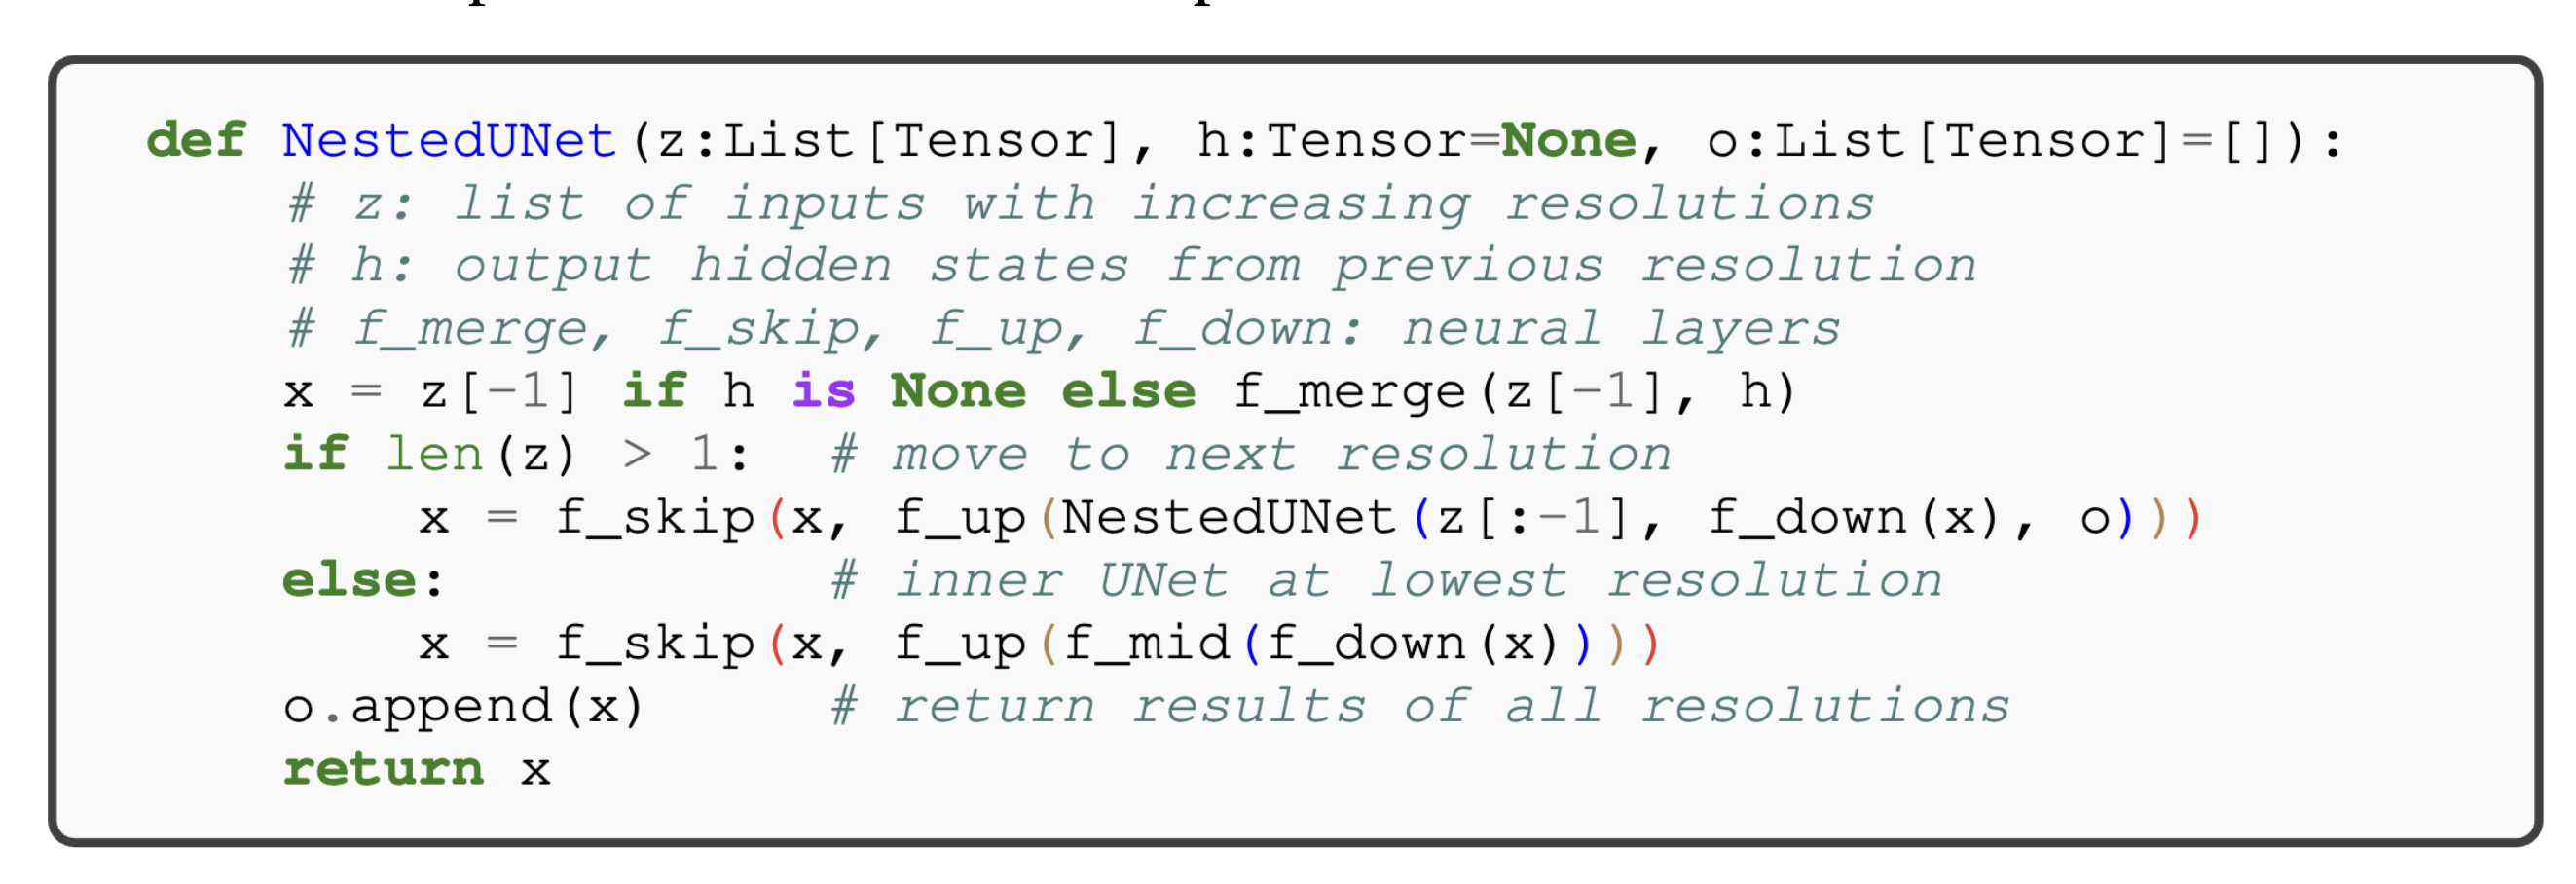

In [4]:
image = Image.open('imgs/nested_unet_img.png')
display(image)

In [ ]:
from torch import nn
import torch
from typing import List

In [5]:
class NestedUNet(nn.Module):
    pass

In [ ]:
def f_merge(z: torch.Tensor, h: torch.Tensor:
    pass

In [ ]:
def f_mid(x: torch.Tensor):
    pass

In [ ]:
def f_down(x: torch.Tensor):
    pass

In [ ]:
def f_up(x: torch.Tensor):
    pass

In [ ]:
def f_skip(x: torch.Tensor):
    pass

In [1]:
def forward(z: List[torch.Tensor], h: torch.Tensor, o:List[torch.Tensor]):
    x = z[-1] if h is None else f_merge(z[-1], h)
    if len(z) > 1:
        x = f_skip(x, f_up(forward(z[:-1], f_down(x), o)))
    else:
        x = f_skip(x, f_up(f_mid(f_down(x))))

NameError: name 'List' is not defined

Base architecture (MDM-S64)

config: resolutions=[64,32,16] resolution_channels =[256 ,512 ,768] num_res_blocks =[2 ,2 ,2] num_attn_layers_per_block =[0 ,1 ,5] num_heads=8, schedule=’cosine’ emb_channels=1024, num_lm_attn_layers =2 , lm_feature_projected_channels =1024


In [15]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.fix_dimension = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(32, out_channels)
        self.norm2 = nn.GroupNorm(32, out_channels)
        
        self.activation = nn.SiLU()
        
    def forward(self, x):
        residual = self.fix_dimension(x)
        x = self.norm1(self.conv1(x))
        x = self.norm2(self.conv2(x))
        return residual + x

In [12]:
class Attention(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_heads: int = 8):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_heads = num_heads
        self.multi_head_attention = nn.MultiheadAttention(num_heads, in_channels, dropout=0.1)
        
        self.k = nn.Conv2d(in_channels, in_channels, kernel_size=1) # не пон, надо сейчас в out_channels или в конце
        self.q = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.v = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        self.activation = nn.Softmax()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x: torch.Tensor):
        q_proj = self.q(x)
        k_proj = self.k(x)
        v_proj = self.v(x)
        
        return self.conv(self.activation(q_proj * k_proj) * v_proj)        

In [13]:
class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

In [16]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

In [14]:
class MDM64(nn.Module):
    def __init__(self, resolutions=[64, 32, 16], channels=[256, 512, 768], num_res_blocks=[2, 2, 2],
                 num_attn_layers=[0, 1, 5], num_heads=8):
        super().__init__()
        
        self.levels = len(resolutions)
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()

        in_channels = 3
        for i in range(self.levels):
            res_blocks = nn.ModuleList([ResidualBlock(in_channels, channels[i])])
            for _ in range(num_res_blocks[i] - 1):
                res_blocks.append(ResidualBlock(channels[i], channels[i]))

            self.down_blocks.append(nn.Sequential(*res_blocks))
            if num_attn_layers[i] > 0:
                self.attention_blocks.append(Attention(channels[i], num_heads))
            else:
                self.attention_blocks.append(nn.Identity())

            if i < self.levels - 1:
                self.down_blocks.append(Downsample(channels[i]))
                in_channels = channels[i]

        for i in reversed(range(self.levels)):
            res_blocks = nn.ModuleList([ResidualBlock(channels[i], channels[i])])
            for _ in range(num_res_blocks[i] - 1):
                res_blocks.append(ResidualBlock(channels[i], channels[i]))

            self.up_blocks.append(nn.Sequential(*res_blocks))
            if i > 0:
                self.up_blocks.append(Upsample(channels[i]))

    def forward(self, x):
        skips = []
        for i in range(self.levels):
            x = self.down_blocks[i](x)
            x = self.attention_blocks[i](x)
            skips.append(x)
            if i < self.levels - 1:
                x = self.down_blocks[i + 1](x)

        for i in reversed(range(self.levels)):
            x = self.up_blocks[i](x)
            x += skips[i]
            if i > 0:
                x = self.up_blocks[i - 1](x)

        return x

In [ ]:
import numpy as np